Table of Contents

* [0 - Setting up environment](#Setupenvironment)
* [1 - Introduction and Data Overview](#introduction)
* [2 - Exploratory Analysis](#eda)
    * [2.1 Euribor 3 month and Marketing outcome](#2.1)
    * [2.2 Age, Job and Marketing outcome](#2.2)
    * [2.3 Number of contacts in a campaign & Previous Number of contacts](#2.3)
* [3 - Data cleaning & engineering](#dce)
    * [3.1 Converting the target vairable to 1 and 0](#3.1)
    * [3.2 Replacing 'unknown' with Nan](#3.2)
    * [3.3 Evaluate the number of incomplete records](#3.3)
    * [3.4 Investigate missing pattern](#3.4)
    * [3.5 Imputing missing values](#3.5)
    * [3.6 Split train test data](#3.6)
    * [3.7 Feature selection](#3.7)
    * [3.8 Re-sampling](#3.8)
* [4 - Prepare data for modeling](#preparedata)
    * [4.1 Data transformation](#4.1)
    * [4.2 Create a base model](#4.2)
* [5 - Model selection](#ms)
    * [5.1 Test model performance using 5 folds](#5.1)
    * [5.2 Plot the performances in each fold ](#5.2)
    * [5.3 Un-tunned models performance on test data](#5.3)
* [6 - Model tuning](#my)
    * [6.1 Random Forest Classifier](#6.1)
    * [6.2 XGB Classifier](#6.2)
    * [6.3 Histogram based Gradient Boosting Classifier](#6.3)
    * [6.4 Tunned models performance on test data](#6.4)
* [7 - Voting Classifiers](#voting)
    * [7.1 Hard voting using un-tunned models](#7.1)
    * [7.2 Soft voting using tunned models](#7.2)
    * [7.3 Compare final voting models' performance with base mod](#7.3)
* [8 - Summary](#summary)

# 0. Set up environment <a name="Setupenvironment"></a>

In [5]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152V2,VGG16


import glob
import cv2

tf.random.set_seed(42)

#import warnings
#warnings.filterwarnings('ignore')

# 1. Introduction and Data Overview<a name="introduction"></a>
---

**Data background**

This dataset of images is obtained from the [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/2) (Version 3), published on 6 January 2018. Guangzhou Women and Children’s Medical Center provides this data as part of its routine clinical care. It contains chest X-ray images of pediatric patients with two categories: Pneumonia and Normal. According to the [World Health Organisation](https://www.who.int/health-topics/pneumonia#tab=tab_1), Pneumonia is a lung infection that causes inflammation of air sacs in the lungs, resulting in symptoms like coughing, fever and fatigue. It is one of the leading causes of death worldwide, especially among children under five years and older adults.

**Project goal**

Our aim is to use **neural networks** to detect pneumonia using historical patient X-ray images. The finalised model provides healthcare professionals with a more accurate and consistent tool for diagnosing pneumonia, leading to potentially earlier and more effective treatment. The primary metrics to optimise for the model are **accuracy and recall** to achieve reliable and consistent results.

**Data overview**

The dataset contains 5863 images, split into 5232 test and 624 train images.
# ---

- Define fixed parameters.




In [6]:
IMG_SIZE = 224
BATCH = 32
SEED = 555

- Import data for processing.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [8]:
main_path = "/content/gdrive/MyDrive/chest/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [9]:
train_size = len(train_normal) + len(train_pneumonia) 
test_size = len(test_normal) + len(test_pneumonia) 
total = train_size + test_size

# View the counts
print(f'The number of train samples is {train_size}.')
print(f'The number of test samples is {test_size}.')
print(f'The total number of samples is {total}.')

The number of train samples is 5246.
The number of test samples is 624.
The total number of samples is 5870.


- Visualise images that are labelled as normal and pueumonia from both train and test sets.

<Figure size 864x864 with 0 Axes>

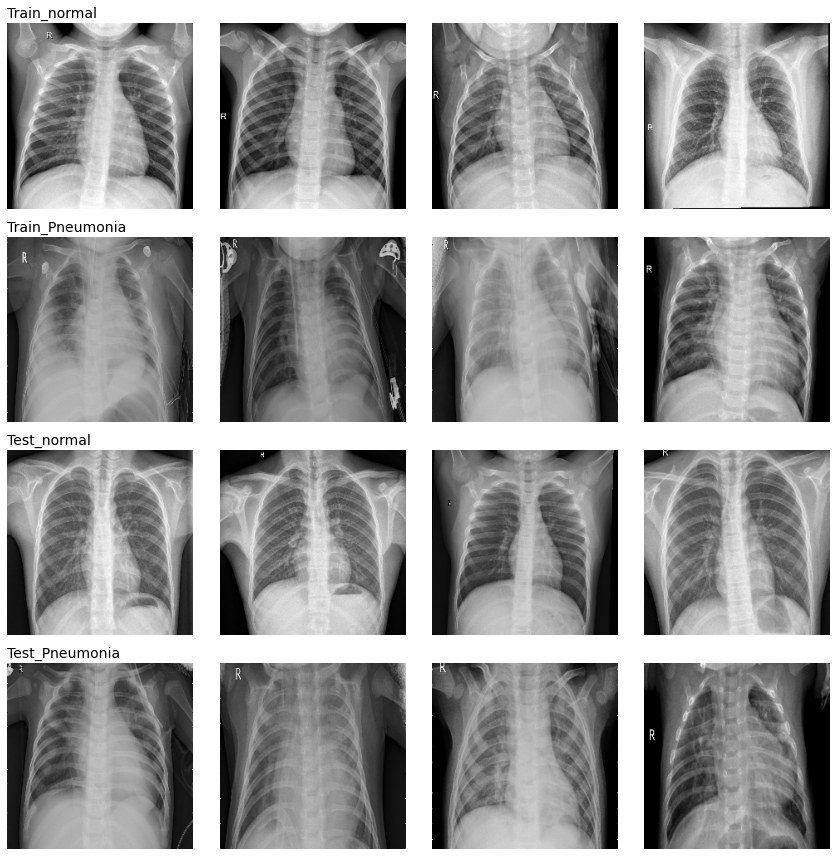

In [10]:
plt.figure(figsize=(12,12))

data=[train_normal, train_pneumonia,test_normal, test_pneumonia]
data_name=['Train_normal','Train_Pneumonia', 'Test_normal','Test_Pneumonia']

fig, axs = plt.subplots(nrows=len(data_name), ncols=4, figsize=(12, 12))

# Iterate over each dataset
for row, dataset in enumerate(data_name):
    # Iterate over the first 4 images in the dataset
    axs[row,0].set_title(f"{data_name[row]}", fontsize=14, loc='left')
    for col in range(4):
      img = cv2.imread(data[row][col])
      img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
      # Plot the image in the corresponding subplot, with each row representing the test and train
      axs[row, col].imshow(img)
      axs[row, col].axis("off")

plt.tight_layout()

plt.show()

### Conclusion and decisions:

---

- Without a trained eye, it is difficult to tell which patient has pneumonia or not.

    We can use **CNN and transfer learning** to help us train a prediction model.


- The images are labelled to indicate if the patient has pneumonia or not.
    
    This is a **binary image classification** project.


---

# 2. Data preprocessing<a name="eda"></a>

---
- We processed the dataset, split it into train, test and validation sets and analysed their distributions.




    
---

- Create a test and train dataframe.

In [11]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [12]:
df_train

,class,image
0,Normal,/content/gdrive/MyDrive/chest/chest_xray/train/NORMAL/NORMAL2-IM-0909-0001.jpeg
1,Normal,/content/gdrive/MyDrive/chest/chest_xray/train/NORMAL/NORMAL2-IM-0907-0001.jpeg
2,Normal,/content/gdrive/MyDrive/chest/chest_xray/train/NORMAL/NORMAL2-IM-0908-0001.jpeg
3,Normal,/content/gdrive/MyDrive/chest/chest_xray/train/NORMAL/NORMAL2-IM-0904-0001.jpeg
4,Normal,/content/gdrive/MyDrive/chest/chest_xray/train/NORMAL/NORMAL2-IM-0903-0001.jpeg
...,...,...
5241,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/train/PNEUMONIA/person1565_bacteria_4095.jpeg
5242,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/train/PNEUMONIA/person465_bacteria_1981.jpeg
5243,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/train/PNEUMONIA/person1550_virus_2691.jpeg
5244,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/train/PNEUMONIA/person410_virus_821.jpeg


In [13]:
df_test

,class,image
0,Normal,/content/gdrive/MyDrive/chest/chest_xray/test/NORMAL/IM-0031-0001.jpeg
1,Normal,/content/gdrive/MyDrive/chest/chest_xray/test/NORMAL/IM-0025-0001.jpeg
2,Normal,/content/gdrive/MyDrive/chest/chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg
3,Normal,/content/gdrive/MyDrive/chest/chest_xray/test/NORMAL/IM-0046-0001.jpeg
4,Normal,/content/gdrive/MyDrive/chest/chest_xray/test/NORMAL/NORMAL2-IM-0343-0001.jpeg
...,...,...
619,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/test/PNEUMONIA/person41_virus_88.jpeg
620,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/test/PNEUMONIA/person36_virus_81.jpeg
621,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/test/PNEUMONIA/person32_virus_71.jpeg
622,Pneumonia,/content/gdrive/MyDrive/chest/chest_xray/test/PNEUMONIA/person21_virus_53.jpeg


In [14]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [15]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

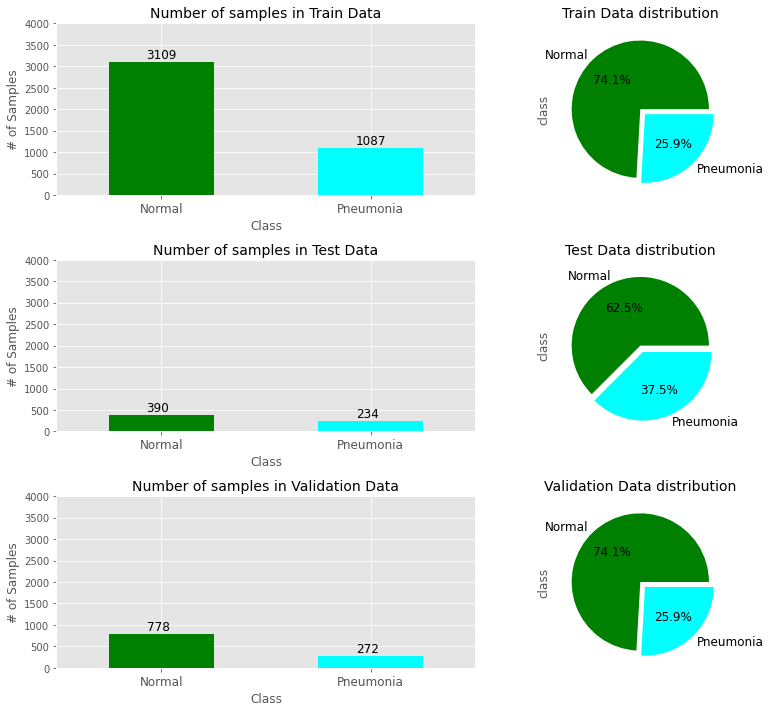

In [16]:
# Create a list of the data you want to plot
data_list = [train_df, df_test, val_df]
data_name=['Train Data','Test Data', 'Validation Data']

plt.style.use('ggplot')

# Create a figure with six subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Loop over the data and create a countplot or pie chart for each
for i, data in enumerate(data_list):
    # Plot the countplot in the first column
    ax1 = data['class'].value_counts().plot(kind='bar', ax=axes[i%3, (i//3)],color=['green','cyan'])
    ax1.set_xlabel("Class", fontsize=12)
    ax1.set_ylabel("# of Samples", fontsize=12)
    ax1.set_ylim(0, 4000)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Normal', 'Pneumonia'], fontsize=12, rotation=360)
    for p in ax1.patches:
        ax1.annotate(p.get_height(), (p.get_x()+0.18, p.get_height()+90), fontsize=12)
    ax1.set_title(f"Number of samples in {data_name[i]}", fontsize=14)
    
    # Plot the pie chart in the second column
    ax2 = data['class'].value_counts().plot(kind='pie', labels=['Normal', 'Pneumonia'], autopct='%1.1f%%', colors=['green','cyan'], 
                                             explode=[0, 0.1], textprops={"fontsize": 12}, ax=axes[i%3, (i//3)+1])
    ax2.set_title(f"{data_name[i]} distribution", fontsize=14)

# Adjust the layout and display the subplots
plt.tight_layout()
plt.show()

---
### Observations and Insights:

- For the 3 sets of data, there is a class imbalance between the positive and negative classes. This can affect the performance of a machine learning model by causing bias towards the majority class and low accuracy on the minority class. 

- The distribution of images across the train, test, and validation data is reasonable, with the majority of the images used for training and smaller numbers being used for testing and validation. This helps to prevent overfitting and provides a good estimate of the model's performance on unseen data.

- The ratio between the positive and negative classes is consistent across all three sets of data. This ensures that the model is trained and tested on a representative sample of the data.


# 3. Data engineering<a name="dce"></a>

---

- Due to a large imbalance between the two classes, we will a create self-defined CNN model and demonstrate why having image augmentation will positively impact prediction accuracy.

In [17]:

train_datagen = ImageDataGenerator(rescale=1/255,
                                  zoom_range = 0.1,
                                  rotation_range = 0.1,
                                  #shear_range=0.1,
                                  width_shift_range = 0.05,
                                  height_shift_range = 0.05)


val_datagen = ImageDataGenerator(rescale=1/255)

ds_train_not_aug=val_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             #directory=train_path, #dataframe contains the full paths
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            #directory=train_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            #directory=test_path,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4196 validated image filenames belonging to 2 classes.
Found 4196 validated image filenames belonging to 2 classes.
Found 1050 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [18]:
print(len(val_df))
print(len(val_df)/BATCH)

print(len(ds_val))
print(len(ds_test))
print(len(df_test))

1050
32.8125
33
624
624


This sample train image is augmented by: 
 Zoom in the x direction:0.99 
 Zoom in the y direction:1.06 
 Shift in the x direction:-9.08 
 Shift in the y direction:-10.23.


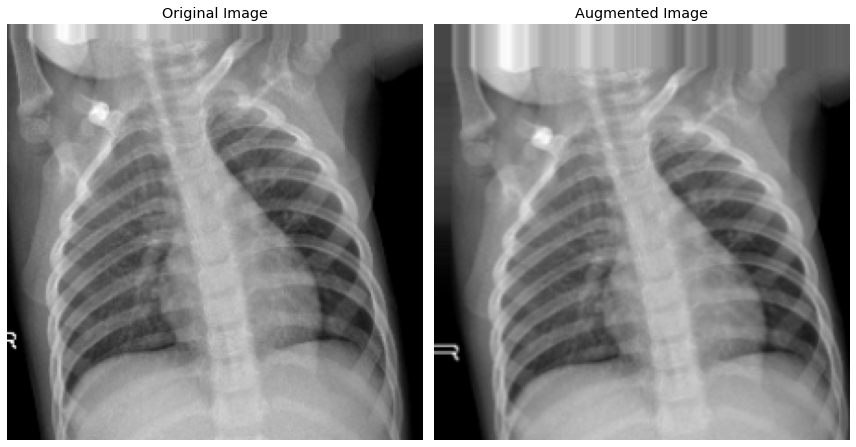

In [19]:
# Get a sample image from the training dataset
img, label = ds_train.next()
img = img[0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# Plot the original image
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis("off")

# Apply data augmentation and plot the augmented image
params = train_datagen.get_random_transform(img.shape)
augmented_img = train_datagen.apply_transform(img, params)
axs[1].imshow(augmented_img)
axs[1].set_title('Augmented Image')
axs[1].axis("off")

# Print out the data augmentation parameters
print(f'This sample train image is augmented by: \n Zoom in the x direction:{params.get("zx"):0.2f} \n Zoom in the y direction:{params.get("zy"):0.2f} \n Shift in the x direction:{params.get("tx"):0.2f} \n Shift in the y direction:{params.get("ty"):0.2f}.')

# Adjust the layout and display the subplots
plt.tight_layout()
plt.show()

In [20]:
#Setting callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)
plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

In [21]:
def get_model_one():
    # Input layer
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Block 1
    x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(inputs)
    #x = layers.Conv2D(filters=8, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    # Block 2
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)


    return model


In [22]:
keras.backend.clear_session()

model_funcs = [get_model_one, get_model_one]
labels = ['without data augmentation','with data augmentation']
aug_histories = {}
aug_pred_labels={}

for i, func in enumerate(model_funcs):
  
  model = func()
  model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics='binary_accuracy')
  
  model.summary()

  if i == 0:
    history = model.fit(ds_train_not_aug,
            batch_size = BATCH, epochs = 50,
            validation_data=ds_val,
            callbacks=[early_stopping, plateau],
            steps_per_epoch=(len(train_df)/BATCH),
            validation_steps=(len(val_df)/BATCH));
  else:
    history = model.fit(ds_train,
            batch_size = BATCH, epochs = 50,
            validation_data=ds_val,
            callbacks=[early_stopping, plateau],
            steps_per_epoch=(len(train_df)/BATCH),
            validation_steps=(len(val_df)/BATCH));

  val_score = model.evaluate(ds_val, steps=len(val_df) / BATCH, verbose=0)
  print(f'Val loss for Model 1 {labels[i]}:', val_score[0])
  print(f'Val accuracy for Model 1 {labels[i]}:', val_score[1])

  test_score = model.evaluate(ds_test, steps=len(ds_test), verbose=0)
  print(f'Test loss for Model 1 {labels[i]}:', test_score[0])
  print(f'Test accuracy for Model 1 {labels[i]}:', test_score[1])

  ds_test.reset()
  prediction = model.predict(ds_test, steps=len(ds_test), verbose=0)
  pred_label = np.where(prediction > 0.5, 1, 0)

  aug_pred_labels[i+1] = pred_label
  aug_histories[i+1] = history

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                                                         

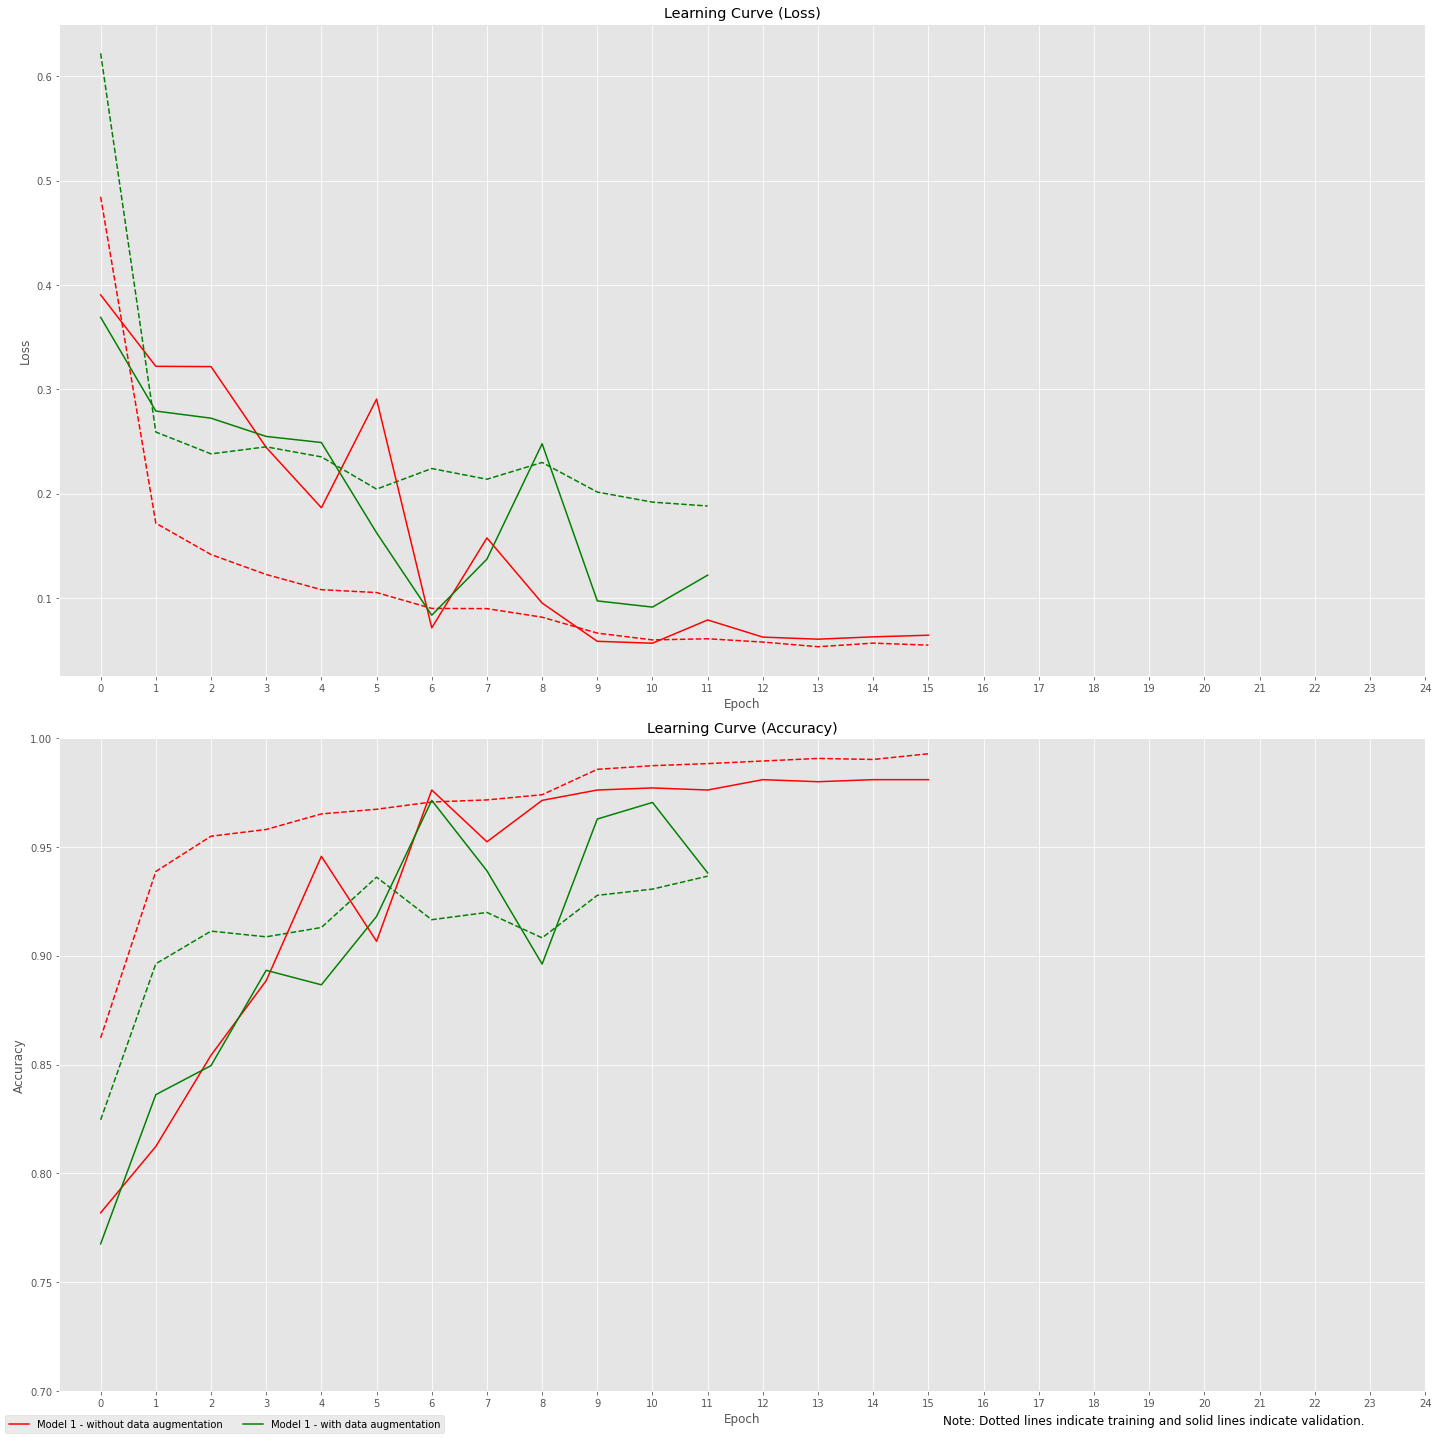

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))
palette = ['red', 'green']
labels = ['Model 1 - without data augmentation', 'Model 1 - with data augmentation']

# First subplot
for i in range(2):
    sns.lineplot(x=aug_histories[i+1].epoch, y=aug_histories[i+1].history['loss'], ax=axs[0], linestyle='dashed', color=palette[i])
    sns.lineplot(x=aug_histories[i+1].epoch, y=aug_histories[i+1].history['val_loss'], ax=axs[0], linestyle='solid', color=palette[i])

# Second subplot
for i in range(2):
    sns.lineplot(x=aug_histories[i+1].epoch, y=aug_histories[i+1].history['binary_accuracy'], ax=axs[1], linestyle='dashed', color=palette[i])
    sns.lineplot(x=aug_histories[i+1].epoch, y=aug_histories[i+1].history['val_binary_accuracy'], ax=axs[1], linestyle='solid', color=palette[i])


axs[0].set_title('Learning Curve (Loss)')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
#axs[0].set_ylim(0, 2)
axs[0].set_xticks(range(0, 25))


axs[1].set_title('Learning Curve (Accuracy)')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylim(0.7, 1)
axs[1].set_xticks(range(0, 25))


# set legend manually with 2 lines and different colors
handles = [plt.Line2D([], [], color=palette[0]),
           plt.Line2D([], [], color=palette[1])]
fig.legend(handles=handles, labels=labels, loc='lower left',ncol=2)
fig.text(0.8, 0.01, 'Note: Dotted lines indicate training and solid lines indicate validation.', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [24]:
aug_performance_scores={}

for i in range(1, 3): #loop 2 models
  model_accuracy = round(accuracy_score(Y_test, aug_pred_labels[i]), 5)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(Y_test, 
                                                                                 aug_pred_labels[i], 
                                                                                 average="weighted")
  aug_performance_scores[i] = [model_accuracy,model_precision,model_recall,model_f1]

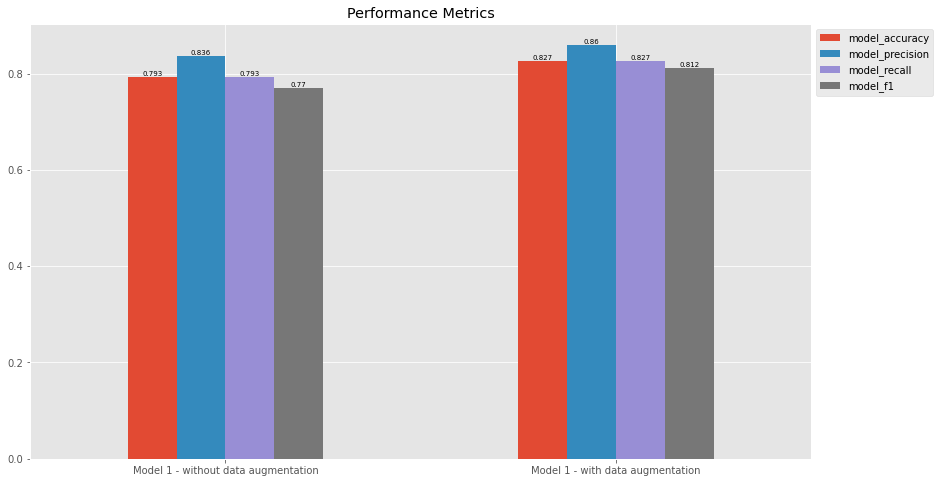

In [25]:
aug_performance_df=pd.DataFrame.from_dict(aug_performance_scores, orient='index',columns=['model_accuracy', 'model_precision', 'model_recall', 'model_f1'])
aug_performance_df = aug_performance_df.round(3)

ax = aug_performance_df.plot(kind="bar", figsize=(14, 8), title='Performance Metrics')
ax.legend(bbox_to_anchor=(1.0, 1.0))

ax.set_xticklabels(labels, rotation=360)

# Add annotations for all columns
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=i.datavalues.astype(str),fontsize=7)

In [26]:
def get_model_two():
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Block One
    x = layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    # Block Two
    x = layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)
    
    # Block Three
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.4)(x)

    # Head
    #x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [27]:
def get_model_three_no_finetuning():

    base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

    base_model.trainable = False

    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [28]:
def get_model_three():

    base_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

# Set the last 4 layers of the base model to be trainable
    for layer in base_model.layers[-6:]:
      layer.trainable = True


    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [29]:
keras.backend.clear_session()

model_funcs = [get_model_three_no_finetuning, get_model_three]
labels = ['without finetuning','with finetuning']
finetune_histories = {}
finetune_pred_labels ={}

for i, func in enumerate(model_funcs):
  
  model = func()
  model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=1e-4), metrics='binary_accuracy')
  
  model.summary()
  
  history = model.fit(ds_train,
            batch_size = BATCH, epochs = 50,
            validation_data=ds_val,
            callbacks=[early_stopping, plateau],
            steps_per_epoch=(len(train_df)/BATCH),
            validation_steps=(len(val_df)/BATCH));

  val_score = model.evaluate(ds_val, steps=len(val_df) / BATCH, verbose=0)
  print(f'Val loss for Model 3 {labels[i]}:', val_score[0])
  print(f'Val accuracy for Model 3 {labels[i]}:', val_score[1])

  test_score = model.evaluate(ds_test, steps=len(ds_test), verbose=0)
  print(f'Test loss for Model 3 {labels[i]}:', test_score[0])
  print(f'Test accuracy for Model 3 {labels[i]}:', test_score[1])

  
  ds_test.reset()
  prediction = model.predict(ds_test, steps=len(ds_test), verbose=0)
  pred_label = np.where(prediction > 0.5, 1, 0)
  
  
  finetune_histories[i+1] = history
  finetune_pred_labels[i+1] = pred_label

94668760/94668760 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

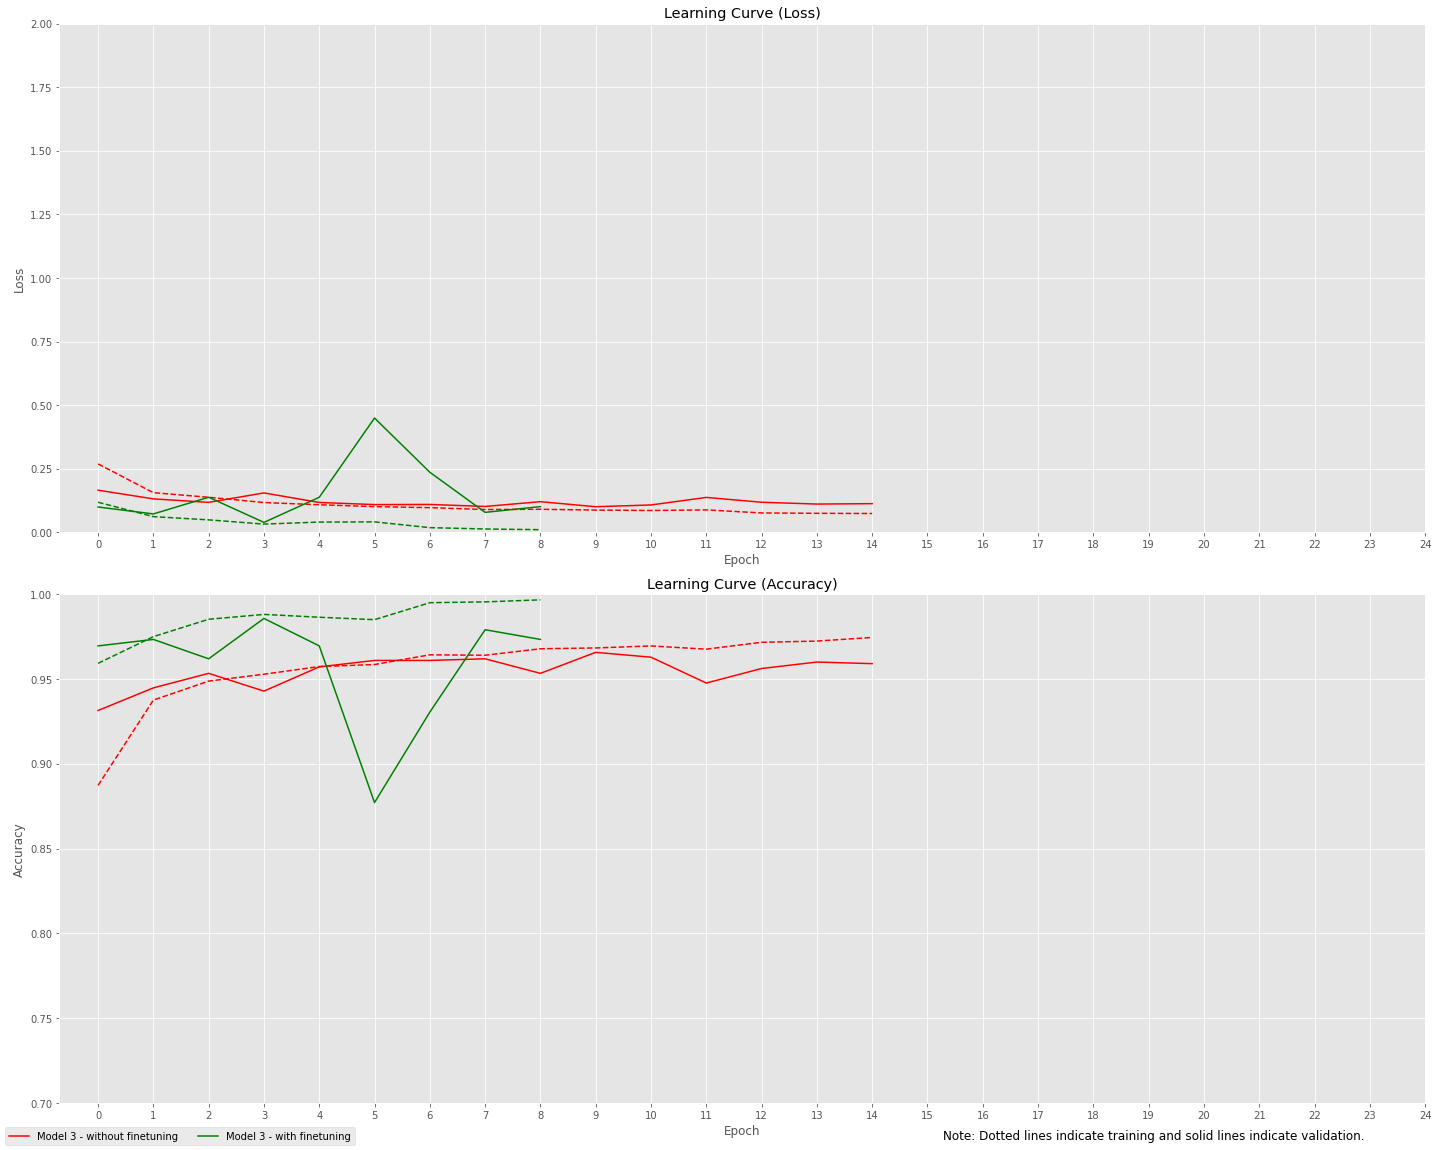

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 16))
palette = ['red', 'green']
labels = ['Model 3 - without finetuning', 'Model 3 - with finetuning']

# First subplot
for i in range(2):
    sns.lineplot(x=finetune_histories[i+1].epoch, y=finetune_histories[i+1].history['loss'], ax=axs[0], linestyle='dashed', color=palette[i])
    sns.lineplot(x=finetune_histories[i+1].epoch, y=finetune_histories[i+1].history['val_loss'], ax=axs[0], linestyle='solid', color=palette[i])

# Second subplot
for i in range(2):
    sns.lineplot(x=finetune_histories[i+1].epoch, y=finetune_histories[i+1].history['binary_accuracy'], ax=axs[1], linestyle='dashed', color=palette[i])
    sns.lineplot(x=finetune_histories[i+1].epoch, y=finetune_histories[i+1].history['val_binary_accuracy'], ax=axs[1], linestyle='solid', color=palette[i])


axs[0].set_title('Learning Curve (Loss)')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylim(0, 2)
axs[0].set_xticks(range(0, 25))


axs[1].set_title('Learning Curve (Accuracy)')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylim(0.7, 1)
axs[1].set_xticks(range(0, 25))


# set legend manually with 2 lines and different colors
handles = [plt.Line2D([], [], color=palette[0]),
           plt.Line2D([], [], color=palette[1])]
fig.legend(handles=handles, labels=labels, loc='lower left',ncol=2)
fig.text(0.8, 0.01, 'Note: Dotted lines indicate training and solid lines indicate validation.', ha='center', va='center', fontsize=12)

fig.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()

In [31]:
finetune_performance_scores={}

for i in range(1, 3): #loop 2 models
  model_accuracy = round(accuracy_score(Y_test, finetune_pred_labels[i]), 5)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(Y_test, 
                                                                                 finetune_pred_labels[i], 
                                                                                 average="weighted")
  finetune_performance_scores[i] = [model_accuracy,model_precision,model_recall,model_f1]

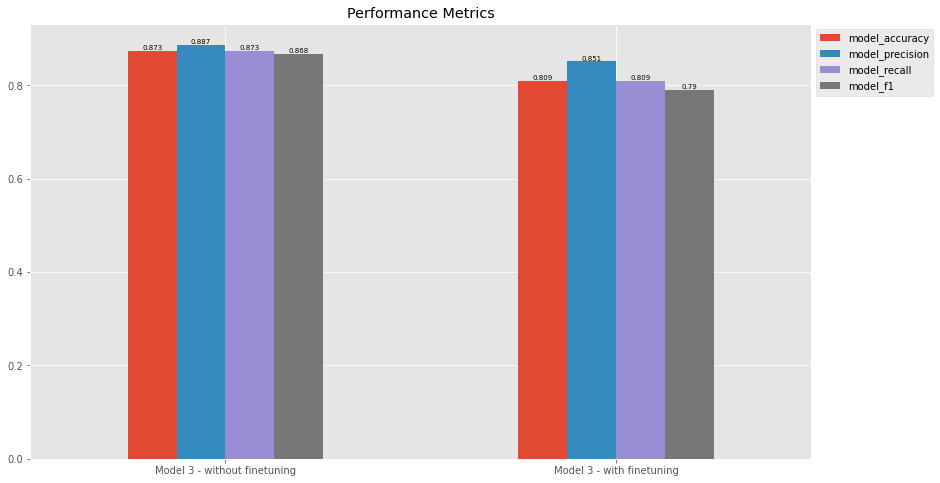

In [32]:
finetune_performance_df=pd.DataFrame.from_dict(finetune_performance_scores, orient='index',columns=['model_accuracy', 'model_precision', 'model_recall', 'model_f1'])
finetune_performance_df = finetune_performance_df.round(3)

ax = finetune_performance_df.plot(kind="bar", figsize=(14, 8), title='Performance Metrics')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_xticklabels(labels, rotation=360)


# Add annotations for all columns
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=i.datavalues.astype(str),fontsize=7)

In [33]:
def get_model_four():


    base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)
    
    # Set the last 13 layers of the base model to be trainable
    for layer in base_model.layers[-13:]:
      layer.trainable = True

    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model


In [ ]:
keras.backend.clear_session()

# Define a list of models
model_funcs = [get_model_one, get_model_two,get_model_three, get_model_four]
optimizer_names = ['RMSprop', 'adam']

# Train each model and store the histories
histories = {}
predictions = {}
pred_labels = {}
val_scores = {}
test_scores = {}

for i, func in enumerate(model_funcs):
    best_val_score = None
    best_model_histories = None
    best_model_predictions = None
    best_model_pred_labels = None
    best_model_val_scores = None
    best_model_test_scores = None
    best_optimizer = None
    
    for optimizer_name in optimizer_names:
            print(f'Training Model {i+1} with optimizer {optimizer_name}')

            model = func()

            if optimizer_name == 'RMSprop':
                model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), metrics=['binary_accuracy'])

            if optimizer_name == 'adam':
                model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['binary_accuracy'])
            
            if optimizer_name == 'Nadam':
              model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Nadam(learning_rate=1e-4), metrics=['binary_accuracy'])


            model.summary()

            history = model.fit(ds_train,
                                batch_size=BATCH, epochs=50,
                                validation_data=ds_val,
                                callbacks=[early_stopping, plateau],
                                steps_per_epoch=(len(train_df) / BATCH),
                                validation_steps=(len(val_df) / BATCH))

            val_score = model.evaluate(ds_val, steps=len(val_df) / BATCH, verbose=0)
            test_score = model.evaluate(ds_test, steps=len(ds_test), verbose=0)
            
            ds_test.reset()
            prediction = model.predict(ds_test, steps=len(ds_test), verbose=0)
            pred_label = np.where(prediction > 0.5, 1, 0)

            if best_val_score is None or val_score[1] > best_val_score[1]:
                best_val_score = val_score
                best_model_histories = history
                best_model_predictions = prediction
                best_model_pred_labels = pred_label
                best_model_val_scores = val_score
                best_model_test_scores = test_score
                best_optimizer = optimizer_name

    histories[i+1] = best_model_histories
    predictions[i+1] = best_model_predictions
    pred_labels[i+1] = best_model_pred_labels
    val_scores[i+1] = best_model_val_scores
    test_scores[i+1] = best_model_test_scores
    
    print(f'Best optimizer for Model {i+1}:', best_optimizer)
    print(f'Best val accuracy for Model {i+1}:', best_val_score[1])
    print(f'Val loss for Model {i+1}:', best_val_score[0])


Training Model 1 with optimizer RMSprop
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 110, 110, 16)     0         
 2D)                 

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 16))
palette = ['red', 'green', 'blue', 'cyan']
labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# First subplot
for i in range(4):
    sns.lineplot(x=histories[i+1].epoch, y=histories[i+1].history['loss'], ax=axs[0], linestyle='dashed', color=palette[i])
    sns.lineplot(x=histories[i+1].epoch, y=histories[i+1].history['val_loss'], ax=axs[0], linestyle='solid', color=palette[i])

# Second subplot
for i in range(4):
    sns.lineplot(x=histories[i+1].epoch, y=histories[i+1].history['binary_accuracy'], ax=axs[1], linestyle='dashed', color=palette[i])
    sns.lineplot(x=histories[i+1].epoch, y=histories[i+1].history['val_binary_accuracy'], ax=axs[1], linestyle='solid', color=palette[i])


axs[0].set_title('Learning Curve (Loss)')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylim(0, 2)
axs[0].set_xticks(range(0, 25))


axs[1].set_title('Learning Curve (Accuracy)')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylim(0.7, 1)
axs[1].set_xticks(range(0, 25))


# set legend manually with 4 lines and different colors
handles = [plt.Line2D([], [], color=palette[0]),
           plt.Line2D([], [], color=palette[1]),
           plt.Line2D([], [], color=palette[2]),
           plt.Line2D([], [], color=palette[3])]
fig.legend(handles=handles, labels=labels, loc='lower left',ncol=4)
fig.text(0.8, 0.01, 'Note: Dotted lines indicate training and solid lines indicate validation.', ha='center', va='center', fontsize=12)

fig.subplots_adjust(bottom=0.2)

plt.tight_layout()
plt.show()

# Performance Metrics

In [ ]:
performance_scores={}

for i in range(1, 5): #loop model 1-4:
  model_accuracy = round(accuracy_score(Y_test, pred_labels[i]), 5)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(Y_test, 
                                                                                 pred_labels[i], 
                                                                                 average="weighted")
  performance_scores[i] = [model_accuracy,model_precision,model_recall,model_f1]

In [ ]:
performance_df=pd.DataFrame.from_dict(performance_scores, orient='index',columns=['model_accuracy', 'model_precision', 'model_recall', 'model_f1'])
performance_df = performance_df.round(3)

ax = performance_df.plot(kind="bar", figsize=(14, 8), title='Performance Metrics')
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Add annotations for all columns
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=i.datavalues.astype(str),fontsize=7)

In [ ]:
for i in range(1, 5): #loop model 1-4:
  confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels[i])
  disp=sns.heatmap(confusion_matrix, annot=True, fmt="d")

  plt.xlabel("Predicted Label", fontsize= 12)
  plt.ylabel("True Label", fontsize= 12)
  disp.set_title(f'Confusion Matrix for Model {i}')

  plt.show()

In [ ]:
for i in range(1, 5): #loop model 1-4:
  print(f'Classification Report for Model {i}:')
  print(metrics.classification_report(Y_test, pred_labels[i], labels = [0, 1]))

In [ ]:
palette = ['red', 'green', 'blue', 'cyan']
labels = []

fig, axs = plt.subplots(figsize=(20, 16))

for i in range(1,5):
    roc_auc = metrics.roc_auc_score(Y_test, predictions[i])
    print(f'ROC_AUC for Model {i} {roc_auc}')
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[i])
    plt.plot(fpr, tpr, color=palette[i-1])
    labels.append(f'Model {i} ROC_AUC = {roc_auc:0.3f}')
  
fig.legend(labels=labels, loc='lower center', ncol=5)
axs.set_xlabel("False Positive Rate", fontsize= 12)
axs.set_ylabel("True Positive Rate", fontsize= 12)
axs.set_title("ROC Curve for Models 1-4", fontsize=16)

plt.show()

In [ ]:
#Check wordcount
import json
def wordcount(nb_filename):
  with open(nb_filename) as json_file:
    data = json.load(json_file)
    wordCount = 0
  for each in data['cells']:
     cellType = each['cell_type']
     if cellType == "markdown":
       content = each['source']
       for line in content:
         temp = [word for word in line.split()]
         wordCount = wordCount + len(temp)
  return wordCount

wordcount('../content/gdrive/My Drive/Colab Notebooks/Untitled0.ipynb')